# Фаза 2 • Неделя 8 • Вторник
## Нейронные сети
### 🔥 PyTorch: MNIST

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

In [3]:
# импортируем torch
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

torch.manual_seed(42)

import torchutils as tu

# импортируем ToTensor чтобы сразу переводить в нужный тип данных
from torchvision import datasets
from torchvision.transforms import ToTensor

import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use("cyberpunk")
import numpy as np 

#### Попробуем классифицировать картинки

Это известный датасет с рукописными цифрами, он встроен в `pytorch` и во многие другие фреймворки. Он сразу задан в формате `Dataset`, так что импортировать TensorDataset необязательно. 

In [4]:
train_dataset = datasets.MNIST(
    # Указываем папку для скачивания
    root = 'data/',
    # Флаг обучающей части выборки
    train = True,
    # Сразу преобразуем в тип Tensor        
    transform = ToTensor(),
    # если отсутствует локально, то скачаем
    download = True)

valid_dataset = datasets.MNIST(
    root = 'data/', 
    train = False, 
    transform = ToTensor()
)

In [5]:
print(f'Shape of train dataset: {train_dataset.data.shape}')
print(f'Shape of valid dataset: {valid_dataset.data.shape}')
print(f'Shape of one example: {train_dataset.data[0].shape}')

Shape of train dataset: torch.Size([60000, 28, 28])
Shape of valid dataset: torch.Size([10000, 28, 28])
Shape of one example: torch.Size([28, 28])


/Users/anton/miniconda3/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


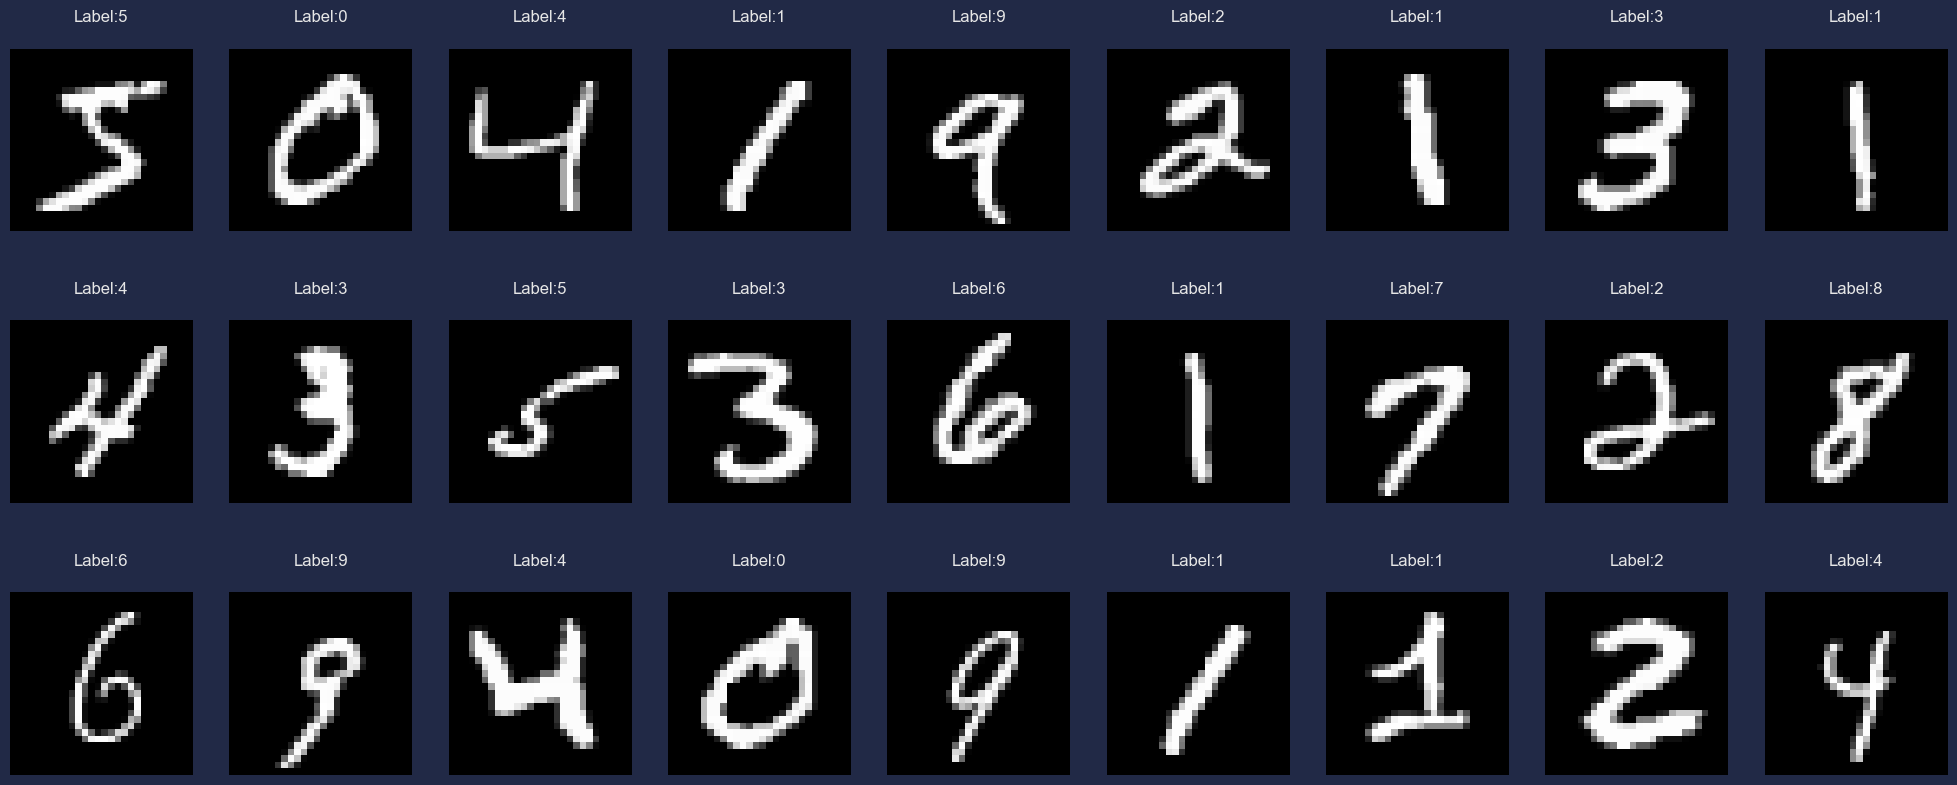

In [6]:
# распечатаем произвольную картинку
fig, ax = plt.subplots(3, 9, figsize=(25, 10))
ax = ax.flatten()
for i, plot in enumerate(ax):
    plot.set_title(f'Label:{train_dataset.train_labels[i].item()}')
    plot.matshow(train_dataset.data[i], cmap='gray')
    plot.axis('off')

In [7]:
BATCH_SIZE=64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

<img src='aux/imgs/mnist.png'>

Сейчас каждый объект – это матрица. Полносвязный слой умеет работать только с векторами, так что мы сразу преобразуем матрицы/картинки в вектора размера 28*28=784

In [9]:
# зададим функцию рисования графиков
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((0, max(history['train_losses'] + history['valid_losses'])+.1))
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((0, 1))
    ax[1].legend()
    
    plt.show()

In [10]:
# задаем последовательную модель
model = nn.Sequential(
    # для выпрямления матрицы в вектор используем Flatten
    nn.Flatten(),
    # (BATCH_SIZE, 784)
    nn.Linear(784, 4), #28*28 = 784
    nn.Sigmoid(),
    nn.Linear(4, 10),  # 10 выходных нейронов – 10 классов
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
    # Мы будем использовать CrossEntropyLoss, pytorch автоматически 
    # вычислит софтмакс, поэтому на последнем слое мы можем его не применять
    # nn.Softmax()
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
)

# задаем функцию потерь для многоклассовой классификации
criterion = nn.CrossEntropyLoss()

# обнуляем history
history = None

🚀 Если у вас доступна видеокарта, её можно подключить для ускорения вычислений!  
🎯 Это пригодится нам в будущем, так как **все вычисляемые объекты** будем отправлять на выбранное устройство.  

🖥️ **Выбор устройства:**  
- 🎮 **CUDA** — графический процессор от NVIDIA  
- 🍏 **MPS** — графический процессор Apple  
- 🏗 **CPU** — центральный процессор *(по умолчанию, можно не указывать)*  

🔧 **Автоматический выбор устройства:**  
```python
DEVICE = 'mps'  # 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
DEVICE = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
model.to(DEVICE)
tu.get_model_summary(model, torch.randn(BATCH_SIZE, 28, 28, device=DEVICE))

Layer    Kernel     Output     Params     FLOPs
0_0            -   [64, 784]        0         0
1_1     [784, 4]     [64, 4]    3,140   401,152
2_2            -     [64, 4]        0     1,024
3_3      [4, 10]    [64, 10]       50     4,480
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
Total FLOPs: 406,656 / 406.66 KFLOPs
-----------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.39
Params size (MB): 0.01
Estimated Total Size (MB): 0.60


In [13]:
# Определяем цикл обучения
def fit_model(
        model: nn.Module, 
        epochs: int, 
        optimizer: torch.optim.Optimizer, 
        history = None
        ) -> dict:
    '''
    model: pytorch model - model to train
    epochs: int          - number of epochs
    plot_every: int      - plot every N iterations
    '''
    
    # будем сохранять значения точности и лосса в history
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    # определяем текущую эпоху обучения
    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = [] 
        for samples, labels in train_loader: 
            
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            y_pred = model(samples)
            
            # Считаем лосс: передаем в функцию потерь предсказания и 
            # настоящие метки классов
            # иногда надо переводить между long() и float(), 
            # об этом pytorch предупредит

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            # print(f'Predictions: {y_pred}')
            # сравниваем предсказания с таргетом и добавляем в 
            # список значение точности
            # BATCH_SIZE x N_CLASSES = 64 X 10 -> argmax -> 64 x 1

            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        # Validation
        model.eval()
    
        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(samples.to(DEVICE))
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))
        
        
        # печатаем результат
        
        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()
    
    # печатаем графики
    plot_history(history)

    return history

In [14]:
# задаем оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
model.to(DEVICE)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=4, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=4, out_features=10, bias=True)
)

In [16]:
# history = fit_model(model, 4, optimizer, history)

## PyTorch Class

Класс на основе `nn.Module` – самый правильный подход к построению моделей во фрейворке `pyTorch`. Функции активации можно задавать как слой: тогда их нужно импортировать из `torch.nn`, иногда можно встретить в примерах, что они расположены в методе `forward` – так тоже можно делать, но надо помнить, что тогда их надо загружать из модуля `torch.nn.functional`. 

In [18]:
# Задаем класс модели
class MnistTorchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flat = nn.Flatten()
        # fully connected 
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.dropout = nn.Dropout()

    # x -> batch_size, 28, 28 -> batch_size, 784
    def forward(self, x):
        # print(f'Input shape: {x.shape}')
        # это способ сделать reshape вектора или матрицы;
        # можно задать слой Flatten в конструкторе, однако такой подход
        # встречается намного чаще
        # [BATCH_SIZE, 28, 28] -> [BATCH_SIZE, 784]
        x = x.view(x.size(0), -1)
        # x.shape > [BATCH_SIZE, 784]
        # x = self.flat(x)
        # Иногда функции активации прописывают в методе forward - это не принципиально
        x_first_out = F.relu(self.fc1(x))
        # print(f'x_first: {x_first_out.size()}')
        x_second_out = self.dropout(F.relu(self.fc2(x_first_out)))
        # print(f'x_second: {x_second_out.size()}')
        # И добавим Softmax, чтобы получать в вероятностях, а не логитах. Но Torch поймет нас и без этого
        x_final = F.softmax(self.fc3(x_second_out))
        # print(f'Final shape: {x_final.shape}')
        return x_final
    
    


# создаем экзепляр класса   
model = MnistTorchClassifier()

# отправляем модель на видеокарту (любое удобное устройство)
model.to(DEVICE);

#torch.optim.Adadelta(), 
# torch.optim.RMSprop(), 
# torch.optim.SGD(), 
# torch.optim.Adagrad()
tu.get_model_summary(model, torch.randn(BATCH_SIZE, 28, 28, device=DEVICE))
history = None

Layer        Kernel      Output    Params       FLOPs
0_fc1       [784, 32]   [64, 32]   25,120   3,209,216
1_fc2        [32, 16]   [64, 16]      528      64,512
2_dropout           -   [64, 16]        0           0
3_fc3        [16, 10]   [64, 10]      170      19,840
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
Total FLOPs: 3,293,568 / 3.29 MFLOPs
-----------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.04
Params size (MB): 0.10
Estimated Total Size (MB): 0.33


/var/folders/ms/2vkb1zvd31g8wvmkgtbs0c0w0000gn/T/ipykernel_65448/861230159.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_final = F.softmax(self.fc3(x_second_out))


------------- Epoch 1 -------------


/var/folders/ms/2vkb1zvd31g8wvmkgtbs0c0w0000gn/T/ipykernel_98018/861230159.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_final = F.softmax(self.fc3(x_second_out))


train: accuracy 0.5720, loss 1.9053
valid: accuracy 0.7896, loss 1.6806
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.7039, loss 1.7776
valid: accuracy 0.8969, loss 1.5770
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.7559, loss 1.7256
valid: accuracy 0.9115, loss 1.5571
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.7879, loss 1.6929
valid: accuracy 0.9167, loss 1.5495
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.8022, loss 1.6766
valid: accuracy 0.9227, loss 1.5422
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.8247, loss 1.6552
valid: accuracy 0.9276, loss 1.5376
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.8386, loss 1.6397
valid: accuracy 0.9287, loss 1.5345
-----------------------------------

------------- Epoch 8

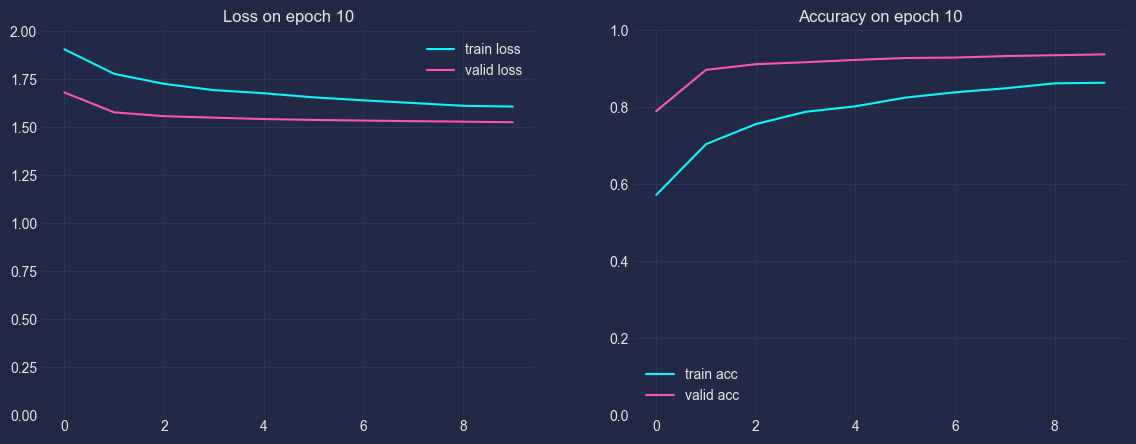

In [29]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=.001)
history = fit_model(model, 10, optimizer=optimizer)

### Пример работы модели на предсказание(inference)

Text(0.5, 1.0, 'real class - 3')

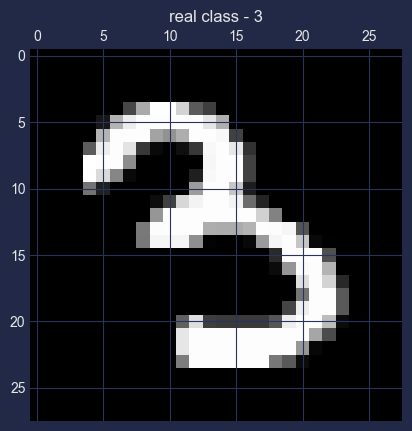

In [19]:
# Возьмем один тестовый батч
test_batch = next(iter(valid_loader))
test_samples, test_targrets = test_batch

# Нариусем график
plt.matshow(test_samples[5].squeeze(0), cmap='grey')
plt.title(f'real class - {test_targrets[5]}')

Вектор вероятностей для элемента tensor([[0.1163, 0.1181, 0.0814, 0.0903, 0.1050, 0.0781, 0.1290, 0.0989, 0.0835,
         0.0993]], device='mps:0', grad_fn=<SoftmaxBackward0>)
Наиболее вероятно, что даннный элемент относится к классу цифры 6


/var/folders/ms/2vkb1zvd31g8wvmkgtbs0c0w0000gn/T/ipykernel_65448/861230159.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_final = F.softmax(self.fc3(x_second_out))


Text(0.5, 1.0, 'real class - 3, pred_class - 6')

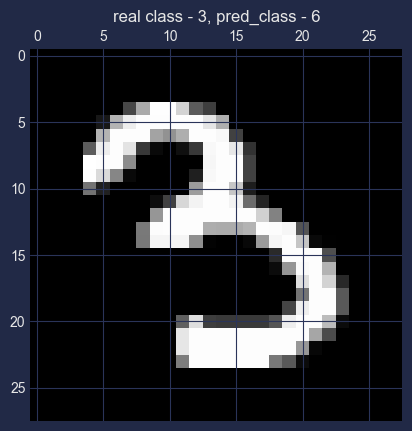

In [20]:
prediction_vector = model.forward(test_samples[5].to(DEVICE)) # Можно просто model(test_samples[5].to(DEVICE)), без forward
prediction_class = torch.argmax(prediction_vector).item() 


print(f'Вектор вероятностей для элемента {prediction_vector}')
print(f'Наиболее вероятно, что даннный элемент относится к классу цифры {prediction_class}')

# Нариусем график
plt.matshow(test_samples[5].squeeze(0), cmap='grey')
plt.title(f'real class - {test_targrets[5]}, pred_class - {prediction_class}')

#### Немного про `view`, `reshape` и `flatten`

In [21]:
# посмотрим отличия view и flatten
tensor = next(iter(train_loader))[0] # достаем из data loader один батч выборки
print(f'Shape before view {tensor.shape}')
print(f'Shape before view {tensor.view(tensor.size(0), -1).shape}')

flat = nn.Sequential(
    nn.Flatten()
)

print(f'Shape before Flatten {tensor.shape}')
print(f'Shape before Flatten {flat(tensor).shape}')

# [batch_size, num_channels, height, width]


Shape before view torch.Size([64, 1, 28, 28])
Shape before view torch.Size([64, 784])
Shape before Flatten torch.Size([64, 1, 28, 28])
Shape before Flatten torch.Size([64, 784])
